# Advanced GeoPandas and Plotting
February 8, 2019  
David Shean

## Objectives
* Continue to explore GeoPandas functionality, including spatial joins
* Explore geospatial hexbin plots

Let's use the ICESat GLAS dataset one final time.  The first problem was one of the extra credit problems from Week 04.  It covers some fundamental concepts (like spatial and attribute joins), so work through it if haven't already.

In [1]:
#%matplotlib widget
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import fiona
plt.rcParams['figure.figsize'] = [10, 8]

## Read in the gpkg of reprojected points that you saved last week

In [2]:
#utm_fn='../04_Fundamentals_CRS_Geom/conus_glas_utm_32611.gpkg'
utm_fn='../week04-fundamentals-crs-geom-jupflug/glas_points.gpkg'
glas_gdf_utm = gpd.read_file(utm_fn)
utm_crs=glas_gdf_utm.crs

## Read in the state polygons

In [3]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
#states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)
states_gdf_utm = states_gdf.to_crs(utm_crs)

# Aggregate GLAS points by state polygons

* Compute number of points and mean elevation
* Generate cloropleth maps for both
* Note: the steps here are the solution I came up with.  If you can figure out a more efficient way to do it, I'd love to hear about it.

## Start with a spatial join between the glas_gdf_utm points and states_gdf_utm polygons
* http://geopandas.org/mergingdata.html
* http://geopandas.org/reference/geopandas.sjoin.html
* Pick an appropriate operation for the spatial join
* Choose the `how` keyword appropriately to preserve the state polygon geometry for each point
* Consider limiting your GLAS GeoDataFrame to the ['glas_z', 'geometry'] columns and states GDF to ['NAME', 'geometry']

In [4]:
# all op are equivalent when joining points to polygons!
# chose right because this will subset the left dataset to points
# in the right, but keep the entirety of the right dataset
pnts_with_state = gpd.sjoin(glas_gdf_utm[['glas_z','geometry']],\
                            states_gdf_utm[['NAME','geometry']],\
                            how="right",op='intersects')
#pnts_with_state.head()

## Sanity check
* There should be a new column for each point with the corresponding state name

In [5]:
pnts_with_state.head()

,index_left,glas_z,NAME,geometry
index_right,,,,
50,0.0,1398.51,Wyoming,"POLYGON ((1590531.644434655 4620093.63035647, ..."
50,1.0,1387.11,Wyoming,"POLYGON ((1590531.644434655 4620093.63035647, ..."
50,2.0,1392.83,Wyoming,"POLYGON ((1590531.644434655 4620093.63035647, ..."
50,3.0,1384.24,Wyoming,"POLYGON ((1590531.644434655 4620093.63035647, ..."
50,4.0,1369.21,Wyoming,"POLYGON ((1590531.644434655 4620093.63035647, ..."


## Now aggregate by state name
* Note: the GeoPandas doc example uses a `dissolve` operation here, which is a wrapper around the `groupby` and `agg` Pandas functions
* But look at the geometry for the points - a bunch of duplicate state polygons.  So `dissolve` would recompute the union between identical geometries for the 1000s of points in each State.  Pretty inefficient.
* Try a `groupby` state name and then `agg` with `['count', 'mean']` to compute both simultaneously for your 'glas_z' values

In [6]:
aggState = pnts_with_state.groupby('NAME')['glas_z'].agg(['count','mean'])

## Sanity check
* That was fast
* Since `groupby` and `agg` are Pandas operation, you should have a new Pandas DataFrame of state names with count and mean columns
    * Note that many states should have 0 count (and NaN mean), as the GLAS points only cover the Western U.S.

In [7]:
aggState

,count,mean
NAME,,
Alabama,0,NaN
Alaska,0,NaN
Arizona,2,1355.220000
Arkansas,0,NaN
California,13865,1701.699116
Colorado,8429,3253.791521
Connecticut,0,NaN
Delaware,0,NaN
District of Columbia,0,NaN


## Remove any states with 0 count and/or NaN mean
* You should now have a regular Pandas DataFrame for the states with GLAS points

In [8]:
pnts_with_state_filt = aggState.loc[aggState['count'] != 0]
pnts_with_state_filt

,count,mean
NAME,,
Arizona,2,1355.220000
California,13865,1701.699116
Colorado,8429,3253.791521
Idaho,7297,1790.290550
Montana,2658,2125.944759
Nevada,12081,1335.431521
New Mexico,209,1835.156699
Oregon,2838,1500.335525
Utah,5498,1439.914989


## OK great, but the state geometry is gone!  How am I going to plot this?
* No sweat, we can use Pandas `merge` to do an attribute join on the state `'NAME'` values, so the state geometry is added to our new DataFrame containing counts and mean elevations
* Then create a new GeoDataFrame for the merged DataFrame, defining the crs appropriately

In [9]:
# restricting the selected states by the filtered states in the 
# left dataframe
statePnts = pd.merge(pnts_with_state_filt, states_gdf_utm[['NAME','geometry']],\
                how = 'left',left_on = 'NAME', right_on = 'NAME')
statePnts

,NAME,count,mean,geometry
0,Arizona,2,1355.220000,"POLYGON ((1432228.492816811 4146494.827579271,..."
1,California,13865,1701.699116,(POLYGON ((550885.8852517313 4191545.687573249...
2,Colorado,8429,3253.791521,"POLYGON ((1916382.394527162 4676934.769584543,..."
3,Idaho,7297,1790.290550,"POLYGON ((1474641.280183331 4832947.375324536,..."
4,Montana,2658,2125.944759,"POLYGON ((1915324.526486489 5142484.501714695,..."
5,Nevada,12081,1335.431521,"POLYGON ((1253794.030952423 4577577.912445022,..."
6,New Mexico,209,1835.156699,"POLYGON ((2116189.252219275 3670119.980989093,..."
7,Oregon,2838,1500.335525,"POLYGON ((583979.6464505595 5055624.242472362,..."
8,Utah,5498,1439.914989,"POLYGON ((1502389.609726466 4636186.871593538,..."
9,Washington,5265,1224.196596,"(POLYGON ((535640.3276472996 5348457.490369, 5..."


In [10]:
from geopandas import GeoDataFrame
# using utm crs defined earlier in the notebook
gdfState = GeoDataFrame(statePnts,geometry=statePnts['geometry'],\
                       crs = utm_crs)
gdfState.crs

{'init': 'epsg:32610'}

## Create a cloropleth map to visualize these counts

Text(0.5, 1.0, 'Number of ICESat points')

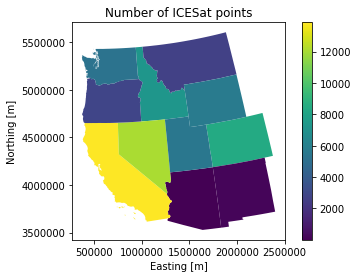

In [11]:
ax = gdfState.plot(column='count')
plt.colorbar(ax.collections[0],ax=ax)
plt.ylabel('Northing [m]')
plt.xlabel('Easting [m]')
plt.title('Number of ICESat points')

## Create a cloropleth map to visualize the mean elevation of all GLAS points in each state

Text(0.5, 1.0, 'Mean ICESat elevation [m]')

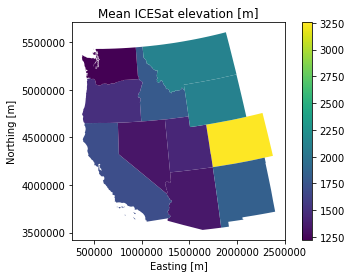

In [12]:
ax = gdfState.plot(column='mean')
plt.colorbar(ax.collections[0],ax=ax)
plt.ylabel('Northing [m]')
plt.xlabel('Easting [m]')
plt.title('Mean ICESat elevation [m]')

# Create a hexbin plot to show point density in regularly spaced grid cells


## First, reproject the points to an equal-area projection
* Define a custom Albers Equal Area proj string `'+proj=aea...'`
    * http://spatialreference.org/ref/esri/102003/
    * https://en.wikipedia.org/wiki/Albers_projection
* Use the GLAS point total_bounds (in lat/lon) to compute a center longitude and center latitude for your projection (You did this in Lab #04)
* Define the two standard parallels (lines of latitude) based on the range of your points
    * Scale is true along these parallels, and distortion increases the further you go from these two parallels, it's important to choose appropriately
    * One approach would be to use min and max point latitude, but this could lead to additional distortion near the center latitude.
    * Could also place them slightly inside your min and max point latitude

In [13]:
# convert previous geodataframe to EPSG 4326
latlonPnts = glas_gdf_utm.to_crs(epsg=4326)
latlonPnts.crs 

{'init': 'epsg:4326', 'no_defs': True}

In [14]:
# get lat/lon boundaries 
# and set the parallels between the min/max and center lat
bounds = latlonPnts.total_bounds
midx = (bounds[0]+bounds[2])/2
midy = (bounds[1]+bounds[3])/2
latyup = (midy+bounds[3])/2
latydw = (midy+bounds[1])/2

In [15]:
AEA = "+proj=aea +lat_1=%(ydw)f +lat_2=%(yup)f +lat_0=%(midy)f +lon_0=%(midx)f +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs"\
                              % {'ydw':latydw,'yup':latyup,'midy':midy,'midx':midx}
albersProj = latlonPnts.to_crs(AEA)
albersProjStates = states_gdf.to_crs(AEA)

## Create scatter plots for your original UTM and reprojected AEA points (sanity check)
* Note the location of the origin for each coordinate system

Text(0.5, 1.0, 'ICESat surface elevation [m] (epsg 32610)')

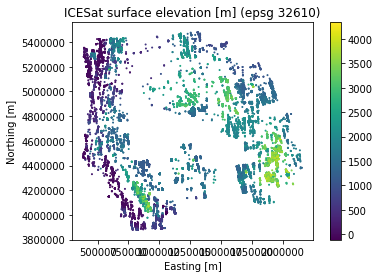

In [16]:
ax = glas_gdf_utm.plot(c=glas_gdf_utm["glas_z"],legend=False,\
                      markersize=1)
c = plt.colorbar(ax.collections[0],ax=ax)
plt.ylabel('Northing [m]')
plt.xlabel('Easting [m]')
plt.title('ICESat surface elevation [m] (epsg 32610)')

Text(0.5, 1.0, 'ICESat surface elevation [m] (epsg 102003)')

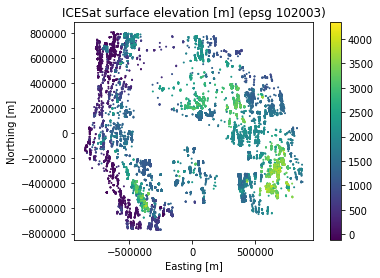

In [17]:
ax2 = albersProj.plot(c=albersProj["glas_z"],legend=False,\
                      markersize=1)
c2 = plt.colorbar(ax2.collections[0],ax=ax2)
plt.ylabel('Northing [m]')
plt.xlabel('Easting [m]')
plt.title('ICESat surface elevation [m] (epsg 102003)')

## Umm, they look the same.  Why am I wasting time on this?

## Check the distances in meters between the min and max point coordinates (both x and y) for each projection
* What do you expect?  Should they be equal?
    * Hint: are UTM and Albers Equal Area equidistant projections?
* Use the GeoDataFrame total_bounds method here, then difference appropriately
* What is the percent difference in the x and y direction?
    * Does this make sense?

#### I'm guessing that the extents should be fairly different. Especially when reprojecting large areas like this.

In [18]:
# bounds for AEA
boundsAEA = albersProj.total_bounds
boundsUTM = glas_gdf_utm.total_bounds

In [19]:
# x/y distances
xxAEA = boundsAEA[2]-boundsAEA[0]
xxUTM = boundsUTM[2]-boundsUTM[0]
yyAEA = boundsAEA[3]-boundsAEA[1]
yyUTM = boundsUTM[3]-boundsUTM[1]

In [20]:
# %difference with respect to UTM!!
print('x perc. diff = %(xdiff)f' % {'xdiff':(xxAEA-xxUTM)/xxUTM})
print('y perc. diff = %(ydiff)f' % {'ydiff':(yyAEA-yyUTM)/yyUTM})

x perc. diff = -0.020562
y perc. diff = -0.014305


## Check the area difference of the convex hulls
* Note: you'll want to use the GeoDataFrame unary_union method to aggregate the points as a MULTIPOINT object, then compute the convex_hull and area (can do this in one line for each GeoDataFrame)

In [21]:
areaConvexAEA = albersProj.unary_union.convex_hull.area
areaConvexUTM = glas_gdf_utm.unary_union.convex_hull.area
#area diff in km^2
(areaConvexAEA-areaConvexUTM)/1000000

-37616.33382759766

## OK, Let's create some hexbin plots
* Hopefully the above got you thinking about projections again.  Using an equal area projection is a good idea for a hexbin or 2D histogram
* Hexbin plots are great for visualizing spatial distribution of point density
* Here are some resources:
    * https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hexbin.html
    * http://darribas.org/gds15/content/labs/lab_09.html
* Create a hexbin that shows the number of points in each cell
    * Play around with the `gridsize` option (or specify the dimensions of your bins) appropriately
    * Use the `mincnt` option to avoid plotting cells with 0 count
    * Play with the vmin and vmax options
    * Overlay the state polygons to help visualize
    * Tweak your xlim and ylim to the GLAS point bounds
* Create a second hexbin plot that shows the median elevation in each bin
    * See documentation for the `C` and `reduce_C_function` options

Text(0.5, 1.0, 'ICESat collection density')

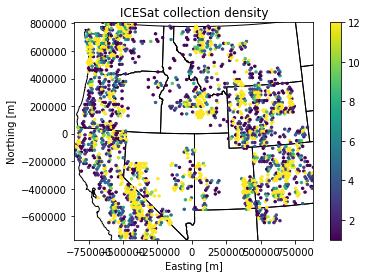

In [22]:
# I know pandas has its own hexbin, but its easier to work
# with the colorbar using matplotlib explicitly
ax = albersProjStates.plot(facecolor='None',edgecolor='black')
plt.hexbin(albersProj['geometry'].x,albersProj['geometry'].y,\
          gridsize=100,mincnt=1,vmin=1,vmax=12)
plt.colorbar()
plt.ylim(boundsAEA[1],boundsAEA[3])
plt.xlim(boundsAEA[0],boundsAEA[2])
plt.ylabel('Northing [m]')
plt.xlabel('Easting [m]')
plt.title('ICESat collection density')

Text(0.5, 1.0, 'ICESat mean elevation')

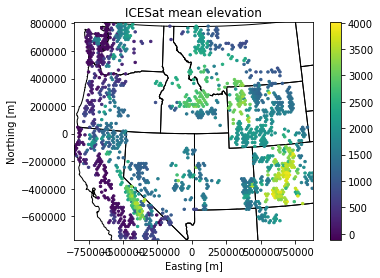

In [23]:
ax = albersProjStates.plot(facecolor='None',edgecolor='black')
plt.hexbin(albersProj['geometry'].x,albersProj['geometry'].y,\
          gridsize=100,mincnt=1,C=albersProj['glas_z'],\
          reduce_C_function=np.mean)
plt.colorbar()
plt.ylim(boundsAEA[1],boundsAEA[3])
plt.xlim(boundsAEA[0],boundsAEA[2])
plt.ylabel('Northing [m]')
plt.xlabel('Easting [m]')
plt.title('ICESat mean elevation')